# Fine-Tuning with CodeComplex


**AIM**: since BigOBench is a "dirty" dataset for the task because the labels for each sample, i.e. the complexities are inferred from a "complexity framework" developed by the authors and therefore potentially incorrect, we try to improve the performance of our custom transformer by using a much smaller but hand-annotated dataset, as suggested in the paper: https://arxiv.org/abs/2401.08719 \\
**Note**: for "complexity framework" they mean a tool developed to infer complexity by analyzing the empirical behavior of the code, looking at execution time (runtime) and memory usage (memory footprint); each code is executed on different input, they fit this data with known complexity functions and choose the function that best fits. \\


We transform the dataset in such a way as to perform a fine-tuning consistent with the training performed via BigOBench, so that the model sees the same "format" of the inputs.
Finally, we make a comparison of the performance obtained on the 10% of the dataset that we use as a test set, comparing the starting custom trasformer and the same transformer after fine-tuning, noting significant improvements.

## Extracting CodeComplex Dataset and setting the model for the Fine-Tuning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

path = 'NLP/Fine-Tuning'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/MyDrive/NLP/Fine-Tuning'

In [ ]:
!pip install datasets
import json
import random

Setting the seed in order to make the training reproducible

In [ ]:
import torch

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

Loading the python_data.json from the CodeComplex Dataset

In [ ]:
import json

file_data = "python_data.jsonl"

data = []

with open(file_data, "r") as f:
    for line in f:
        data.append(json.loads(line))

print(f"Number of elements {len(data)}")

Number of elements 4900


In [ ]:
print(data[0])

{'src': "from math import sqrt\n\na, v = map(int, input().split())\nl, d, w = map(int, input().split())\n\ndef findt(u, v, a, dist):\n\tfront = (v*v-u*u)/(2*a)\n\tif front > dist:\n\t\treturn (sqrt(u*u+2*a*dist)-u)/a\n\treturn (v-u)/a + (dist-front)/v\n\ndef solve(a, v, l, d, w):\n\tif v <= w or 2*a*d <= w*w:\n\t\treturn findt(0, v, a, l)\n\tafter = findt(w, v, a, l-d)\n\tpeak = sqrt(a*d + w*w/2)\n\tif peak > v:\n\t\ttravel = (v*v-w*w/2)/a\n\t\tbefore = (2*v-w)/a + (d-travel)/v\n\telse:\n\t\tbefore = (2*peak-w)/a\n\treturn before + after\n\nprint(f'{solve(a, v, l, d, w):.8f}')", 'complexity': 'constant', 'problem': '0005_D', 'from': 'CODEFORCES', 'tags': 'implementation,math'}


In [ ]:
final_dataset = []

with open(file_data, "r") as f:
    for line in f:
        data = json.loads(line)

        if "src" in data and "complexity" in data:
            entry = {
                "solution_code": data["src"],
                "time_complexity": data["complexity"]
            }
            final_dataset.append(entry)

print(f"Total entry created: {len(final_dataset)}")

Total entry created: 4900


In [ ]:
final_dataset

[{'solution_code': "from math import sqrt\n\na, v = map(int, input().split())\nl, d, w = map(int, input().split())\n\ndef findt(u, v, a, dist):\n\tfront = (v*v-u*u)/(2*a)\n\tif front > dist:\n\t\treturn (sqrt(u*u+2*a*dist)-u)/a\n\treturn (v-u)/a + (dist-front)/v\n\ndef solve(a, v, l, d, w):\n\tif v <= w or 2*a*d <= w*w:\n\t\treturn findt(0, v, a, l)\n\tafter = findt(w, v, a, l-d)\n\tpeak = sqrt(a*d + w*w/2)\n\tif peak > v:\n\t\ttravel = (v*v-w*w/2)/a\n\t\tbefore = (2*v-w)/a + (d-travel)/v\n\telse:\n\t\tbefore = (2*peak-w)/a\n\treturn before + after\n\nprint(f'{solve(a, v, l, d, w):.8f}')",
  'time_complexity': 'constant'},
 {'solution_code': "from math import *\na, vm = map(int, input().split())\nl, d, vd = map(int, input().split())\nif vm <= vd or sqrt(2 * a * d) <= vd:\n    if vm ** 2 / (2 * a) >= l:\n        ans = sqrt(2 * l / a)\n    else:\n        ans = vm / a + (l - vm ** 2 / (2 * a)) / vm\nelse:\n    s1 = (vm ** 2 - vd ** 2) / (2 * a)\n    if s1 >= (l - d):\n        ans = (sqrt(

The dataset contains 5 classes belonging to the 7 classes on which our transformer was trained, but it also contains two other classes that our model has never seen (np and cubic). For this reason, we remove the samples belonging to those two classes, thus maintaining a dataset compatible with our model.

In [ ]:
set_complexity = set(entry["time_complexity"] for entry in final_dataset)

print("Complexity classes present in the dataset:")
for cls in sorted(set_complexity):
    print(f"  - {cls}")

Complexity classes present in the dataset:
  - constant
  - cubic
  - linear
  - logn
  - nlogn
  - np
  - quadratic


In [ ]:
compatible_classes = {"constant", "linear", "logn", "nlogn", "quadratic"}

In [ ]:
final_dataset = [
    entry for entry in final_dataset
    if entry["time_complexity"] in compatible_classes
]

print(f"Filtered Dataset with elements: {len(final_dataset)}")

Filtered Dataset with elements: 3766


In [ ]:
class_mapping = {
    "constant": "O(1)",
    "linear": "O(n)",
    "logn": "O(logn)",
    "nlogn": "O(nlogn)",
    "quadratic": "O(n**2)"
}

In [ ]:
final_dataset = [
    {
        "solution_code": entry["solution_code"],
        "time_complexity": class_mapping[entry["time_complexity"]]
    }
    for entry in final_dataset
    if entry["time_complexity"] in class_mapping
]

In [ ]:
set_complexity = set(entry["time_complexity"] for entry in final_dataset)

print("Complexity classes present in the dataset:")
for cls in sorted(set_complexity):
    print(f"  - {cls}")

Complexity classes present in the dataset:
  - O(1)
  - O(logn)
  - O(n)
  - O(n**2)
  - O(nlogn)


In [ ]:
final_dataset

[{'solution_code': "from math import sqrt\n\na, v = map(int, input().split())\nl, d, w = map(int, input().split())\n\ndef findt(u, v, a, dist):\n\tfront = (v*v-u*u)/(2*a)\n\tif front > dist:\n\t\treturn (sqrt(u*u+2*a*dist)-u)/a\n\treturn (v-u)/a + (dist-front)/v\n\ndef solve(a, v, l, d, w):\n\tif v <= w or 2*a*d <= w*w:\n\t\treturn findt(0, v, a, l)\n\tafter = findt(w, v, a, l-d)\n\tpeak = sqrt(a*d + w*w/2)\n\tif peak > v:\n\t\ttravel = (v*v-w*w/2)/a\n\t\tbefore = (2*v-w)/a + (d-travel)/v\n\telse:\n\t\tbefore = (2*peak-w)/a\n\treturn before + after\n\nprint(f'{solve(a, v, l, d, w):.8f}')",
  'time_complexity': 'O(1)'},
 {'solution_code': "from math import *\na, vm = map(int, input().split())\nl, d, vd = map(int, input().split())\nif vm <= vd or sqrt(2 * a * d) <= vd:\n    if vm ** 2 / (2 * a) >= l:\n        ans = sqrt(2 * l / a)\n    else:\n        ans = vm / a + (l - vm ** 2 / (2 * a)) / vm\nelse:\n    s1 = (vm ** 2 - vd ** 2) / (2 * a)\n    if s1 >= (l - d):\n        ans = (sqrt(4 * 

### Clean and Normalize code

We make the same cleaning process already done in creating_dataset notebook for the BigOBench Dataset.

In [ ]:
!pip install black
!pip install astor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.3 MB/s eta 0:00:00


In [ ]:
import black
import logging
import re

logger = logging.getLogger(__name__)

singlequote_str_pattern = r"\".*?\""
double_quote_str_pattern = r"\'.*?\'"
singlequote_docstring_pattern = r"^\s*'{3,}[\s\S]*?'{3,}"
doublequote_docstring_pattern = r"^\s*\"{3,}[\s\S]*?\"{3,}"
singleline_comment_pattern = r"#[^\r\n]*$"

# Remove all docstrings
docstrings_regex = "(" \
+ "|".join([r"\n?" + singlequote_docstring_pattern,
            r"\n?" + doublequote_docstring_pattern]) \
+ ")"
def remove_docstrings(code):
  return re.sub(docstrings_regex, "", code, flags=re.MULTILINE)

# Remove single line comments outside of strings literals ("#', '#', """#""", '''#''')
pattern = "(" \
+ "|".join([singlequote_str_pattern,
            double_quote_str_pattern,
            singlequote_docstring_pattern,
            doublequote_docstring_pattern]) \
+ ")|(" \
+ r"\n?" + singleline_comment_pattern \
+ ")"
def replacer(match):
  # Remove group 2 if no group 1 match
  if match.group(2) is not None:
    return ""
  else:
    return match.group(1)
def remove_singleline_comments(code):
  return re.compile(pattern, re.MULTILINE).sub(replacer, code)

# Final function to clean the code
def clean_code(input_code: str) -> str:
  # Remove docstrings
  code = remove_docstrings(input_code)

  # Remove single line comments
  code = remove_singleline_comments(code)

  # Remove __author__, __version__, etc.
  code = re.sub(r"^__\w+__\s*=.*\n", "", code, flags=re.MULTILINE)

  # Format code so that it is PEP 8 compliant https://peps.python.org/pep-0008/
  # => standardize indentation (4 spaces per level), remove extra white spaces...
  try:
    code = black.format_str(code, mode=black.FileMode())
  except Exception as e:
    logger.warning(f"Code cleaning failed: {str(e)}. Skipping code formatting.")
    return

  return code

In [ ]:
import ast
import astor

class CodeBlockTagger(ast.NodeVisitor):
    def __init__(self):
        self.blocks = {
            "imports": [],
            "functions": [],
            "global": []
        }

    def visit_Module(self, node):
        global_block = []

        for stmt in node.body:
            if isinstance(stmt, (ast.Import, ast.ImportFrom)):
                try:
                    self.blocks["imports"].append(astor.to_source(stmt).strip())
                except Exception:
                    continue
            elif isinstance(stmt, ast.FunctionDef):
                self.blocks["functions"].append(astor.to_source(stmt).strip())
            else:
                try:
                    code = astor.to_source(stmt).strip()
                    global_block.append(code)
                except Exception:
                    continue

        if global_block:
            self.blocks["global"].append("\n".join(global_block))


def tag_code_blocks(code: str) -> str:
    try:
        tree = ast.parse(code)
        tagger = CodeBlockTagger()
        tagger.visit(tree)

        parts = []

        if tagger.blocks["imports"]:
            parts.append("<IMPORTS_START>\n" + "\n".join(tagger.blocks["imports"]) + "\n<IMPORTS_END>")

        for func in tagger.blocks["functions"]:
            parts.append(f"<FUNC_DEF_START>\n{func}\n<FUNC_DEF_END>")

        for glob in tagger.blocks["global"]:
            parts.append(f"<GLOBAL_CODE_START>\n{glob}\n<GLOBAL_CODE_END>")

        return "\n\n".join(parts)

    except Exception as e:
        return f"⚠️ Parsing failed: {e}"

In [ ]:
import ast
import astor
import builtins
import sys

class CodeNormalizer(ast.NodeTransformer):
    def __init__(self):
        super().__init__()
        self.global_var_map = {}
        self.func_map = {}
        self.counter = {"var": 0, "func": 0}
        self.builtin_names = set(dir(builtins))
        self.standard_modules = set(sys.builtin_module_names)
        self.imported_names = set()
        self.extra_known_names = {'exit', 'quit', 'help', 'copyright', 'credits', 'license'}
        self.shadowed_names = set()
        self.local_var_map = None

    def _get_var_name(self, original):
        if (original in self.builtin_names or
            original in self.standard_modules or
            original in self.imported_names or
            original in self.extra_known_names) and original not in self.shadowed_names:
            return original

        if self.local_var_map is not None:
            if original in self.global_var_map:
                return self.global_var_map[original]
            if original not in self.local_var_map:
                new_name = f"var_{self.counter['var']}"
                self.counter['var'] += 1
                self.local_var_map[original] = new_name
            return self.local_var_map[original]
        else:
            if original not in self.global_var_map:
                self.global_var_map[original] = f"var_{self.counter['var']}"
                self.counter['var'] += 1
            return self.global_var_map[original]

    def _get_func_name(self, original):
        if (original in self.builtin_names or
            original in self.standard_modules or
            original in self.imported_names or
            original in self.extra_known_names) and original not in self.shadowed_names:
            return original

        if original not in self.func_map:
            self.func_map[original] = f"func_{self.counter['func']}"
            self.counter['func'] += 1
        return self.func_map[original]

    def visit_Import(self, node):
        for alias in node.names:
            self.imported_names.add(alias.asname or alias.name)
        return node

    def visit_ImportFrom(self, node):
        for alias in node.names:
            self.imported_names.add(alias.asname or alias.name)
        return node

    def visit_FunctionDef(self, node):
        if node.name in self.builtin_names or node.name in self.extra_known_names:
            self.shadowed_names.add(node.name)
        node.name = self._get_func_name(node.name)
        for arg in node.args.args:
            if arg.arg not in self.global_var_map:
                self.global_var_map[arg.arg] = f"var_{self.counter['var']}"
                self.counter['var'] += 1

        old_local_map = self.local_var_map
        self.local_var_map = {}

        self.generic_visit(node)

        self.local_var_map = old_local_map
        return node

    def visit_arg(self, node):
        if node.arg not in self.global_var_map:
            self.global_var_map[node.arg] = f"var_{self.counter['var']}"
            self.counter['var'] += 1
        node.arg = self.global_var_map[node.arg]
        return node

    def visit_Name(self, node):
        parent = getattr(node, 'parent', None)

        if ((node.id in self.builtin_names or
             node.id in self.standard_modules or
             node.id in self.imported_names or
             node.id in self.extra_known_names)
            and node.id not in self.shadowed_names):
            return node

        if isinstance(parent, ast.Call) and parent.func == node:
            node.id = self._get_func_name(node.id)
        elif isinstance(node.ctx, (ast.Load, ast.Store, ast.Del)):
            node.id = self._get_var_name(node.id)
        return node

    def generic_visit(self, node):
        for child in ast.iter_child_nodes(node):
            child.parent = node
        return super().generic_visit(node)

def normalize_code(code: str) -> str:
    try:
        tree = ast.parse(code)
        normalizer = CodeNormalizer()
        tree = normalizer.visit(tree)
        ast.fix_missing_locations(tree)
        normalized_code = astor.to_source(tree)
        return normalized_code
    except Exception as e:
        print(f"⚠️ Parsing failed: {e}")
        return code

### Tokenizer

Declaring the tokenizer as done in the training of the custom Transformer.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1

In [ ]:
print(tokenizer.tokenize("<IMPORTS_START>"))
print(tokenizer.tokenize("<IMPORTS_END>"))
print(tokenizer.tokenize("<FUNC_DEF_START>"))
print(tokenizer.tokenize("<FUNC_DEF_END>"))
print(tokenizer.tokenize("<GLOBAL_CODE_START>"))
print(tokenizer.tokenize("<GLOBAL_CODE_END>"))

['<', 'IM', 'P', 'ORTS', '_', 'ST', 'ART', '>']
['<', 'IM', 'P', 'ORTS', '_', 'END', '>']
['<', 'FUN', 'C', '_', 'DEF', '_', 'ST', 'ART', '>']
['<', 'FUN', 'C', '_', 'DEF', '_', 'END', '>']
['<', 'GL', 'OB', 'AL', '_', 'C', 'ODE', '_', 'ST', 'ART', '>']
['<', 'GL', 'OB', 'AL', '_', 'C', 'ODE', '_', 'END', '>']


In [ ]:
my_special_tags = ['<IMPORTS_START>', '<IMPORTS_END>',
                   '<FUNC_DEF_START>', '<FUNC_DEF_END>',
                   '<GLOBAL_CODE_START>', '<GLOBAL_CODE_END>'
                    ]


special_tokens_dict = {'additional_special_tokens': my_special_tags}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print(f"Original Vocabulary: {tokenizer.vocab_size - num_added_toks}")
print(f"Added {num_added_toks} new tokens.")
print(f"New dimension of the tokenizer's vocabulary: {len(tokenizer)}")

Original Vocabulary: 50259
Added 6 new tokens.
New dimension of the tokenizer's vocabulary: 50272


In [ ]:
print(tokenizer.tokenize("<IMPORTS_START>"))
print(tokenizer.tokenize("<IMPORTS_END>"))
print(tokenizer.tokenize("<FUNC_DEF_START>"))
print(tokenizer.tokenize("<FUNC_DEF_END>"))
print(tokenizer.tokenize("<GLOBAL_CODE_START>"))
print(tokenizer.tokenize("<GLOBAL_CODE_END>"))

['<IMPORTS_START>']
['<IMPORTS_END>']
['<FUNC_DEF_START>']
['<FUNC_DEF_END>']
['<GLOBAL_CODE_START>']
['<GLOBAL_CODE_END>']


Filtering our dataset considering only the input codes with max 512 tokens.

In [ ]:
MAX_TOKENS = 512

final_dataset = [
    entry for entry in final_dataset
    if len(tokenizer.tokenize(entry['solution_code'])) <= MAX_TOKENS
]

print(f"Total number of example after filtering: {len(final_dataset)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (2257 > 512). Running this sequence through the model will result in indexing errors


Total number of example after filtering: 3113


In [ ]:
for entry in final_dataset:
    entry["solution_code"] = tag_code_blocks(normalize_code(clean_code(entry["solution_code"])))

print(f"Total couple after normalizing: {len(final_dataset)}")

Total couple after normalizing: 3113


In [ ]:
print(final_dataset[0]["solution_code"])
print(final_dataset[0]['time_complexity'])

<IMPORTS_START>
from math import sqrt
<IMPORTS_END>

<FUNC_DEF_START>
def func_0(var_5, var_1, var_0, var_6):
    var_7 = (var_1 * var_1 - var_5 * var_5) / (2 * var_0)
    if var_7 > var_6:
        return (sqrt(var_5 * var_5 + 2 * var_0 * var_6) - var_5) / var_0
    return (var_1 - var_5) / var_0 + (var_6 - var_7) / var_1
<FUNC_DEF_END>

<FUNC_DEF_START>
def func_1(var_0, var_1, var_2, var_3, var_4):
    if var_1 <= var_4 or 2 * var_0 * var_3 <= var_4 * var_4:
        return func_0(0, var_1, var_0, var_2)
    var_8 = func_0(var_4, var_1, var_0, var_2 - var_3)
    var_9 = sqrt(var_0 * var_3 + var_4 * var_4 / 2)
    if var_9 > var_1:
        var_10 = (var_1 * var_1 - var_4 * var_4 / 2) / var_0
        var_11 = (2 * var_1 - var_4) / var_0 + (var_3 - var_10) / var_1
    else:
        var_11 = (2 * var_9 - var_4) / var_0
    return var_11 + var_8
<FUNC_DEF_END>

<GLOBAL_CODE_START>
var_0, var_1 = map(int, input().split())
var_2, var_3, var_4 = map(int, input().split())
print(f'{func_1(var_0

In [ ]:
classes = ['O(1)', 'O(logn)', 'O(n)', 'O(n**2)', 'O(n*m)', 'O(n+m)', 'O(nlogn)']

label2id = {label: idx for idx, label in enumerate(classes)}
id2label = {idx: label for label, idx in label2id.items()}

In [ ]:
print(label2id)

{'O(1)': 0, 'O(logn)': 1, 'O(n)': 2, 'O(n**2)': 3, 'O(n*m)': 4, 'O(n+m)': 5, 'O(nlogn)': 6}


In [ ]:
for example in final_dataset:
    example['label'] = label2id[example['time_complexity']]

Creating The tokenized dataset

90% Training, 10% Testing

In [ ]:
from datasets import Dataset, DatasetDict

random.shuffle(final_dataset)
split = int(0.90 * len(final_dataset))
train_data = final_dataset[:split]
test_data = final_dataset[split:]

dataset = DatasetDict({
    'train': Dataset.from_list(train_data),
    'test': Dataset.from_list(test_data)
})

def tokenize_function(examples):
    tokenized = tokenizer(
        examples['solution_code'],
        padding='max_length',
        truncation=True,
        max_length=512,
        add_special_tokens=True
    )
    tokenized['label'] = examples['label']
    return tokenized


tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2801 [00:00<?, ? examples/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['solution_code', 'time_complexity', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2801
    })
    test: Dataset({
        features: ['solution_code', 'time_complexity', 'label', 'input_ids', 'attention_mask'],
        num_rows: 312
    })
})

### Import the model to fine-tune it

Collate + dataLoader functions

In [ ]:
import torch
from torch.utils.data import DataLoader


train_data = tokenized_dataset['train']
test_data = tokenized_dataset['test']


def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
    labels = torch.stack([torch.tensor(item['label']) for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }


train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True,
                              collate_fn=collate_fn, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64,
                            collate_fn=collate_fn, num_workers=4, pin_memory=True)

Declaring the transformer: d_model = 256, nhead=8, num_layers = 4

In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]  # broadcast over batch
        return x

class ComplexityClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels, d_model=256, nhead=8, num_layers=4, max_len=512, dropout=0.4):
        super(ComplexityClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_labels)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)                  # [B, L, D]
        x = self.pos_encoder(x)                        # [B, L, D]

        attn_mask = attention_mask == 0                # [B, L] boolean mask
        x = self.transformer_encoder(x, src_key_padding_mask=attn_mask)

        x = x[:, 0, :]     # [CLS] token embedding
        x = self.layer_norm(x)
        x = self.dropout(x)
        logits = self.classifier(x)                    # [B, num_labels]
        return logits

In [ ]:
vocab_size = tokenizer.get_vocab().__len__()

model = ComplexityClassifier(
    vocab_size=vocab_size,
    num_labels=len(label2id),
    d_model=256,
    nhead=8,
    num_layers=4
)

Fine-Tuning pre-trained custom model

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ComplexityClassifier(
  (embedding): Embedding(50272, 256)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (classifier): Linear(in_features=256, out_features=7, bias=True)
)

## Loop Training

Optmize training with cuDNN because input of fixed dimension

In [ ]:
torch.backends.cudnn.benchmark = True

Just 10 epochs of training on the training set, i.e 90% of initial dataset.

<ipython-input-38-9c09dd3987dc>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/44 [00:00<?, ?it/s]<ipython-input-38-9c09dd3987dc>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 44/44 [00:06<00:00,  6.59it/s, loss=1.09]



Epoch 1 completed.
Average Training Loss: 1.3157
Training Accuracy: 0.6030


Epoch 2/10: 100%|██████████| 44/44 [00:05<00:00,  8.20it/s, loss=1.28]



Epoch 2 completed.
Average Training Loss: 1.1632
Training Accuracy: 0.6733


Epoch 3/10: 100%|██████████| 44/44 [00:05<00:00,  8.18it/s, loss=1.03]



Epoch 3 completed.
Average Training Loss: 1.0958
Training Accuracy: 0.7055


Epoch 4/10: 100%|██████████| 44/44 [00:05<00:00,  8.19it/s, loss=1.26]



Epoch 4 completed.
Average Training Loss: 1.0512
Training Accuracy: 0.7308


Epoch 5/10: 100%|██████████| 44/44 [00:05<00:00,  8.12it/s, loss=1.12]



Epoch 5 completed.
Average Training Loss: 1.0165
Training Accuracy: 0.7437


Epoch 6/10: 100%|██████████| 44/44 [00:05<00:00,  8.16it/s, loss=1.03]



Epoch 6 completed.
Average Training Loss: 0.9893
Training Accuracy: 0.7562


Epoch 7/10: 100%|██████████| 44/44 [00:05<00:00,  8.14it/s, loss=0.805]



Epoch 7 completed.
Average Training Loss: 0.9677
Training Accuracy: 0.7633


Epoch 8/10: 100%|██████████| 44/44 [00:05<00:00,  8.12it/s, loss=0.936]



Epoch 8 completed.
Average Training Loss: 0.9462
Training Accuracy: 0.7733


Epoch 9/10: 100%|██████████| 44/44 [00:05<00:00,  8.10it/s, loss=0.952]



Epoch 9 completed.
Average Training Loss: 0.9432
Training Accuracy: 0.7797


Epoch 10/10: 100%|██████████| 44/44 [00:05<00:00,  8.11it/s, loss=1.01]



Epoch 10 completed.
Average Training Loss: 0.9308
Training Accuracy: 0.7840


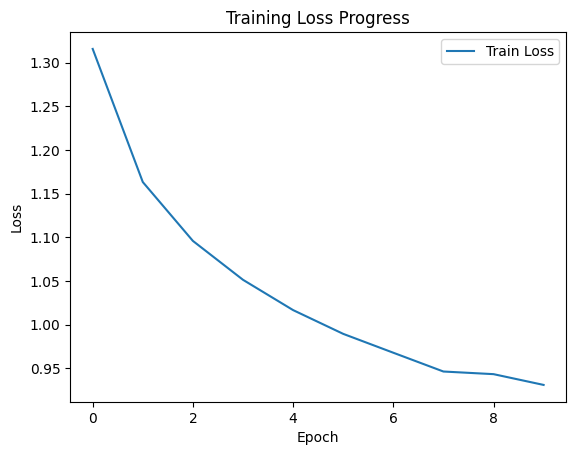

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler


num_epochs = 10
learning_rate = 1e-5
MAX_GRAD_NORM = 1.0


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses = []
scaler = GradScaler()

model.train()

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        with autocast():
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct / total
    train_losses.append(avg_loss)

    print(f"\nEpoch {epoch+1} completed.")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {accuracy:.4f}")


torch.save(model.state_dict(), "final_finetuned_model.pt")

plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Progress")
plt.legend()
plt.show()

## Testing and comparison

In this section, we want to compare the model performance before and after fine-tuning using codeComplex dataset.


Declaration of model_base, the model before the fine-tuning.

In [ ]:
model_base = ComplexityClassifier(
    vocab_size=vocab_size,
    num_labels=len(label2id),
    d_model=256,
    nhead=8,
    num_layers=4
)

model_base.load_state_dict(torch.load("best_model.pt"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_base.to(device)

ComplexityClassifier(
  (embedding): Embedding(50272, 256)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (classifier): Linear(in_features=256, out_features=7, bias=True)
)

In [ ]:
!pip install seaborn scikit-learn

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


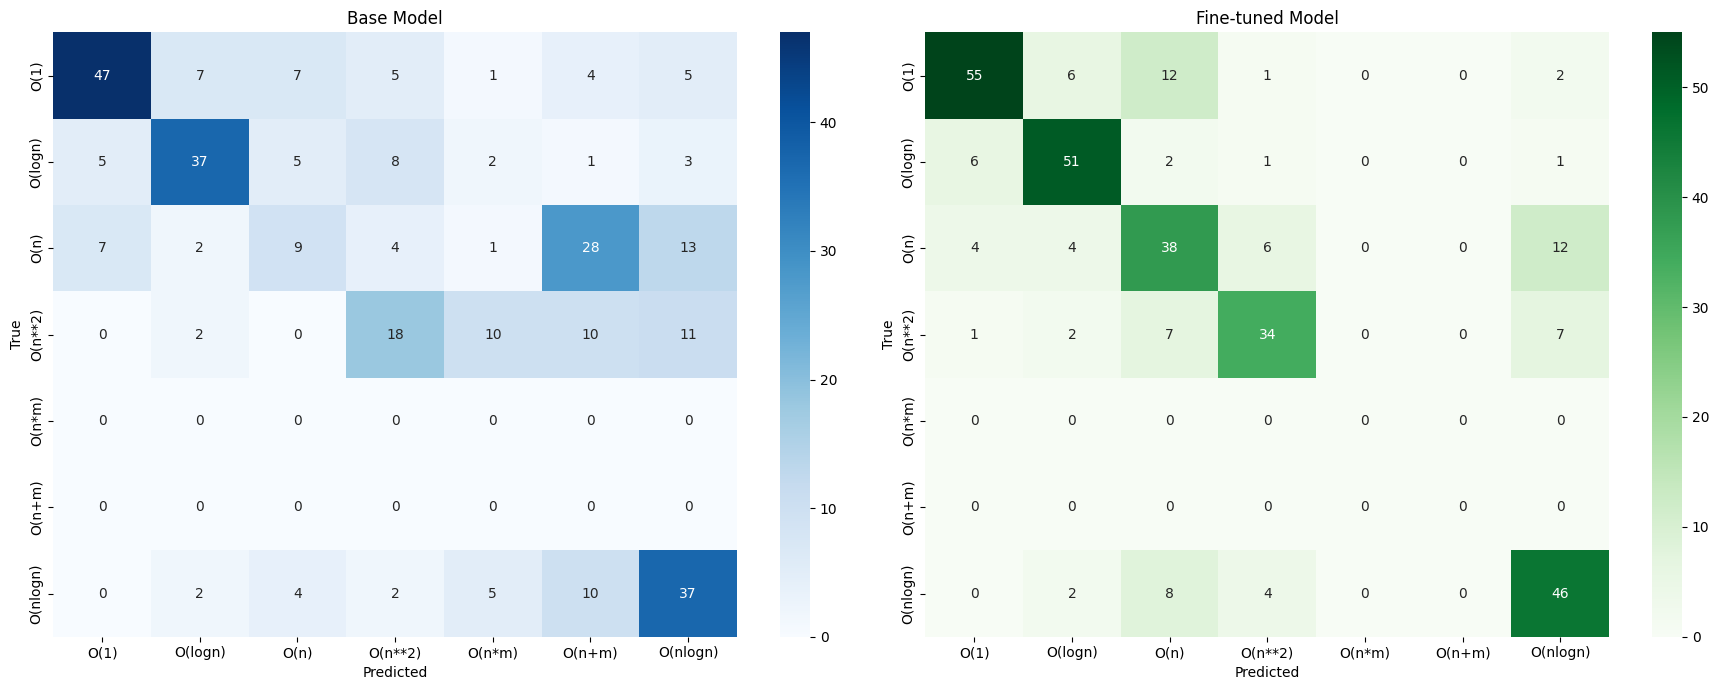

=== Base Model Report ===
              precision    recall  f1-score   support

        O(1)       0.80      0.62      0.70        76
     O(logn)       0.74      0.61      0.67        61
        O(n)       0.36      0.14      0.20        64
     O(n**2)       0.49      0.35      0.41        51
      O(n*m)       0.00      0.00      0.00         0
      O(n+m)       0.00      0.00      0.00         0
    O(nlogn)       0.54      0.62      0.57        60

    accuracy                           0.47       312
   macro avg       0.42      0.33      0.36       312
weighted avg       0.60      0.47      0.52       312


=== Fine-tuned Model Report ===
              precision    recall  f1-score   support

        O(1)       0.83      0.72      0.77        76
     O(logn)       0.78      0.84      0.81        61
        O(n)       0.57      0.59      0.58        64
     O(n**2)       0.74      0.67      0.70        51
      O(n*m)       0.00      0.00      0.00         0
      O(n+m)       

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def get_preds_labels(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label_ids = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_ids = torch.argmax(logits, dim=1)

            preds.extend(pred_ids.cpu().tolist())
            labels.extend(label_ids.cpu().tolist())
    return preds, labels

# Get predictions
all_preds_ft, all_labels_ft = get_preds_labels(model, test_dataloader)
all_preds_base, all_labels_base = get_preds_labels(model_base, test_dataloader)


class_names = [id2label[i] for i in range(len(id2label))]


# Confusion Matrices
cm_ft = confusion_matrix(all_labels_ft, all_preds_ft, labels=[0,1,2,3,4,5,6])
cm_base = confusion_matrix(all_labels_base, all_preds_base, labels=[0,1,2,3,4,5,6])

# 📊 Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_title("Base Model")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(cm_ft, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_title("Fine-tuned Model")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

plt.tight_layout()
plt.show()

# 📄 Classification Reports
print("=== Base Model Report ===")
report_base = classification_report(
    all_labels_base, all_preds_base,
    labels=[0,1,2,3,4,5,6],
    target_names=class_names,
    zero_division=0
)
print(report_base)

print("\n=== Fine-tuned Model Report ===")
report_ft = classification_report(
    all_labels_ft, all_preds_ft,
    labels=[0,1,2,3,4,5,6],
    target_names=class_names,
    zero_division=0
)
print(report_ft)


**Performance Comparison: Base Model vs Fine-Tuned Model**

**Accuracy**

- Base Model: **47%**
- Fine-Tuned model **72%**

>  An improvement of **+25 percentage points**, which highlights a notable capacity for generalization of the model after fine-tuning.

**Confusion Matrices**

- The matrix appears to be slightly diagonalized, with the presence of predictions on hallucinated classes not present in the Test Set.
- The fine-tuned model has a more defined and diagonalized structure, demonstrating better generalization in the task.

**Final Considerations** \\
The model has benefited significantly from fine-tuning, in particular:

- Improved precision and recall on all classes present.
- No incorrect attempts on hallucinated class O(n+m) and O(n*m)
- Increased overall accuracy and then robustness of the model.
